In [1]:
import pandas as pd
import geopandas
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import nuts
import settings
import plots
import eust

In [2]:
nuts_table = nuts.get_nuts_candidates()
EU28_countries = list(nuts_table.country_code.unique())

In [3]:
refareas = pd.read_csv(settings.REFERENCE_AREAS_PATH, index_col='geo')
refareas

,UAA,UAA_XJ2000_J3000
geo,,
AT,2.72689,2.28822
AT1,1.09884,1.08506
AT11,0.18197,0.17671
AT12,0.90885,0.90100
AT13,0.00802,0.00735
...,...,...
UKM3,0.79834,0.48694
UKM5,0.47877,0.31144
UKM6,2.76356,0.43391


In [4]:
harvest = pd.read_csv(settings.HARVEST_PATH, index_col='geo')
harvest

,UAA,UAA_XJ2000_J3000
geo,,
AT,34.822616,31.372186
AT1,15.792107,15.704185
AT11,2.432277,2.405337
AT12,13.916372,13.861194
AT13,0.097659,0.096332
...,...,...
UKM3,13.680010,8.397701
UKM5,8.409825,5.636565
UKM6,47.173386,7.513101


In [5]:
excretion = pd.read_csv(settings.EXCRETION_PATH, index_col='geo').excretion
excretion

geo
AT      27.834650
AT11     0.395425
AT12     6.347312
AT13     0.002201
AT21     2.369130
          ...    
UKM2    10.211552
UKM3    11.429717
UKM5     4.001366
UKM6     6.979625
UKN0    23.973491
Name: excretion, Length: 286, dtype: float64

In [6]:
mineral = pd.read_csv(settings.MINERAL_FERTILIZER_PATH, index_col='geo').mineral
mineral

geo
AT      17.261000
AT1      6.955574
AT11     1.341202
AT12     7.997492
AT13     0.050766
          ...    
UKM3     3.771635
UKM5     2.261876
UKM6    13.056016
UKN      2.735834
UKN0     2.735834
Name: mineral, Length: 427, dtype: float64

# Gather quantities for refarea alternatives

In [7]:
quantities_all = {
    k: pd.DataFrame(
        dict(
            harvest=harvest[k],
            excretion=excretion,
            mineral=mineral,
            refarea=refareas[k],
        )
    )
    .reindex(nuts_table.index)
    for k in refareas.columns
}
quantities_all

{'UAA':         harvest  excretion    mineral  refarea
 geo                                           
 AT    34.822616  27.834650  17.261000  2.72689
 AT1   15.792107        NaN   6.955574  1.09884
 AT11   2.432277   0.395425   1.341202  0.18197
 AT12  13.916372   6.347312   7.997492  0.90885
 AT13   0.097659   0.002201   0.050766  0.00802
 ...         ...        ...        ...      ...
 UKM3  13.680010  11.429717   3.771635  0.79834
 UKM5   8.409825   4.001366   2.261876  0.47877
 UKM6  47.173386   6.979625  13.056016  2.76356
 UKN   17.927024        NaN   2.735834  1.04614
 UKN0  17.927024  23.973491   2.735834  1.04614
 
 [390 rows x 4 columns],
 'UAA_XJ2000_J3000':         harvest  excretion    mineral  refarea
 geo                                           
 AT    31.372186  27.834650  17.261000  2.28822
 AT1   15.704185        NaN   6.955574  1.08506
 AT11   2.405337   0.395425   1.341202  0.17671
 AT12  13.861194   6.347312   7.997492  0.90100
 AT13   0.096332   0.002201   0.05

# Calculate surplus per hectare

In [8]:
def calculate_surplus(quantities):
    return quantities.eval('(excretion + mineral - harvest) / refarea')

surplus_all = {
    k: v.pipe(calculate_surplus)
    for k, v in quantities_all.items()
}

# Compare country-level surplus calculated on different NUTS levels

If the data are consistent and have sufficiently high coverage, the results should agree rather closely but need not be exactly identical.

In [9]:
def country_sum_on_level(d, nuts_level):
    return (
        d
        .pipe(nuts.filter_nuts_level, nuts_level)
        .join(nuts_table.country_code)
        .groupby('country_code')
        .apply(lambda g: g.sum(skipna=False))
    )

def country_sum_on_levels(d, nuts_levels):
    return pd.concat(
        {
            nuts_level: country_sum_on_level(d, nuts_level)
            for nuts_level in nuts_levels
        },
        axis=1
    )

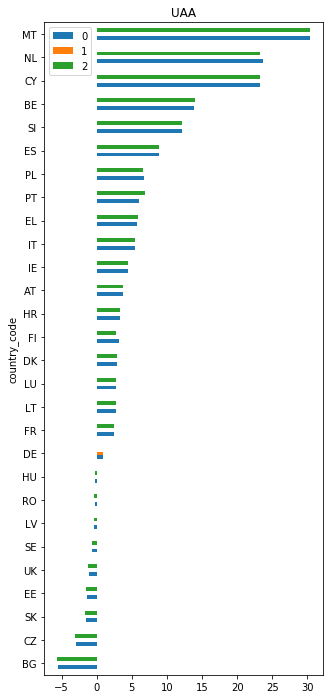

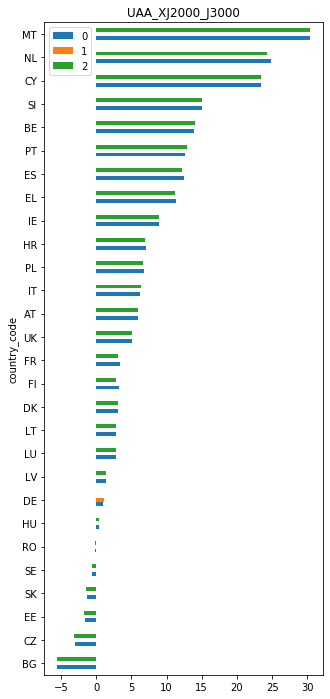

In [10]:
nuts_levels = [0, 1, 2]

for variant, q in quantities_all.items():
    ax = (
        country_sum_on_levels(q, nuts_levels)
        .stack(0)
        .pipe(calculate_surplus)
        .unstack()
        .sort_values(0)
        .plot
        .barh(figsize=(5, 12))
    )
    ax.set_title(variant)

# Select NUTS level to use for each country

In [11]:
selected_nuts_level = (
    pd.Series(
        {
            **{k: 2 for k in EU28_countries},
            **{'DE': 1}, # exceptions
        },
    )
    .rename_axis('country_code')
    .rename('nuts_level')
)

selected_regions = (
    nuts_table
    .reset_index()
    .merge(selected_nuts_level.reset_index(), on=['country_code', 'nuts_level'], how='inner')
    .set_index('geo')
    .index
)
selected_regions

def get_selected_subset(d, level=None):
    return d.reindex(selected_regions, level=level)

In [12]:
selected_regions

Index(['AT11', 'AT12', 'AT13', 'AT21', 'AT22', 'AT31', 'AT32', 'AT33', 'AT34',
       'BE10',
       ...
       'UKK2', 'UKK3', 'UKK4', 'UKL1', 'UKL2', 'UKM2', 'UKM3', 'UKM5', 'UKM6',
       'UKN0'],
      dtype='object', name='geo', length=243)

In [104]:
quantities = {
    k: v.pipe(get_selected_subset)
    for k, v in quantities_all.items()
}

rates = {
    k: v.div(v["refarea"], axis=0).drop(columns="refarea")
    for k, v in quantities.items()
}

surplus = {
    k: v.pipe(get_selected_subset)
    for k, v in surplus_all.items()
}

# Prepare for plotting

In [99]:
nuts_geo = geopandas.read_file(settings.NUTS_GIS_PATH).set_index('NUTS_ID').loc[selected_regions]

def plot_variable_choropleth(s, ax=None, **kwargs):
    key = s.name
    
    d = nuts_geo[['geometry']].join(s, how='inner')
    
    kwargs_final = {
        'legend_kws': {
            'loc': 'upper left',
            'bbox_to_anchor': (1.05, 1.1),
            'borderaxespad': 0,
            'frameon': False,
            'title': 'kg P / ha',
        },
        **plots.CHOROPLETH_KWS[key],
        **kwargs,
    }
    
    ax = plots.plot_europe_choropleth(d, key, ax=ax, **kwargs_final)
    return ax

In [100]:
# Figure sizes etc
COLWIDTH = 76 / 25.4
TEXTWIDTH = 160 / 25.4

sns.set(
    font="Arial",
    rc={
        "xtick.labelsize": 8.5,
        "ytick.labelsize": 8.5,
        "axes.titlesize": 9,
        "axes.labelsize": 8.5,
        "legend.title_fontsize": 8.5,
        "legend.fontsize": 8.5,
        "text.usetex": False,
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "mathtext.rm": "Arial",
        "mathtext.fontset": "custom",
    },
)


def adjust_print_plot(fig, **kwargs):
    defaults = dict(left=0, bottom=0, right=1, top=0.97, wspace=0.05, hspace=0.05)
    
    fig.subplots_adjust(**{**defaults, **kwargs})

# Plot surplus terms

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


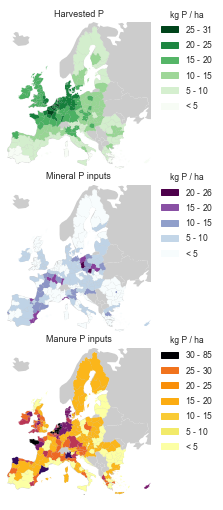

In [107]:
fig, axs = plt.subplots(nrows=3, figsize=(COLWIDTH, COLWIDTH * 2.3))

subplots = [
    dict(
        title='Harvested P',
        variable='harvest',
    ),
    dict(
        title='Mineral P inputs',
        variable='mineral',  
    ),
    dict(
        title='Manure P inputs',
        variable='excretion',
    )
]

for ax, sp in zip(axs, subplots):
    variable = sp['variable']
    plot_variable_choropleth(        
        rates['UAA'][variable].rename(variable),
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.7)
fig.savefig('outdata/figures/Fig2.pdf')

# Plot surplus with both reference areas

/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))
/home/rasmus/.local/share/virtualenvs/code-a3t2G2j4/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


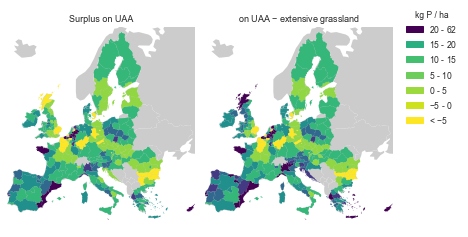

In [102]:
fig, axs = plt.subplots(ncols=2, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

subplots = [
    dict(
        title='Surplus on UAA',
        variant='UAA',
        legend=False,
    ),
    dict(
        title='on UAA $-$ extensive grassland',
        variant='UAA_XJ2000_J3000',
        legend=True,        
    )    
]

for ax, sp in zip(axs, subplots):
    plot_variable_choropleth(
        surplus[sp['variant']].rename('surplus'),
        legend=sp['legend'],
        ax=ax,
    )
    ax.set_title(sp['title'])
    
adjust_print_plot(fig, right=0.85)
fig.savefig('outdata/figures/Fig3.pdf')

In [276]:
(scatter_data['UAA'] / area_scale).describe()

count    243.000000
mean       0.717010
std        0.770102
min        0.001980
25%        0.192990
50%        0.509000
75%        0.929545
max        5.295680
Name: UAA, dtype: float64

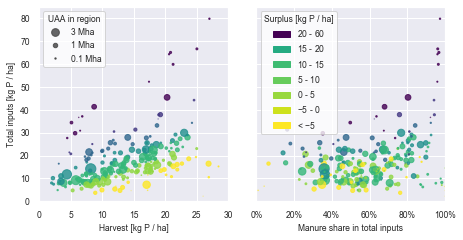

In [353]:
import mapclassify

surplus_scheme = mapclassify.UserDefined(
    surplus['UAA'],
    plots.CHOROPLETH_KWS['surplus']['bin_uls'],
)
surplus_cmap = plots.CHOROPLETH_KWS['surplus']['cmap']
surplus_fmt = plots.CHOROPLETH_KWS['surplus']['legend_fmt']

binned_surplus = pd.Series(data=surplus_scheme.yb, index=surplus['UAA'].index).rename('binned_surplus')
marker = 'o'
area_scale = 20
alpha = 0.8

scatter_data = (
    rates['UAA']
    .join(binned_surplus)
    .join(refareas['UAA'].rename('UAA').mul(area_scale))
    .assign(
        input_sum=lambda d: d.mineral + d.excretion,
        frac_manure=lambda d: d.excretion / d.input_sum
    )
)
scatter_data = scatter_data.sample(len(scatter_data), replace=False) # shuffle randomly

fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(TEXTWIDTH, COLWIDTH * 1.1))

harvest_ax, frac_ax = axs

axs[0].set_ylabel('Total inputs [kg P / ha]')


harvest_ax.scatter(
    x='harvest',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap=surplus_cmap,
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

harvest_ax.set_xlabel('Harvest [kg P / ha]')
harvest_ax.set_xlim(0, 30)

for ax in axs:
    ax.set_ylim(0, 85)


frac_ax.scatter(
    x='frac_manure',
    y='input_sum',
    c='binned_surplus',
    s='UAA',
    cmap='viridis_r',
    data=scatter_data,
    marker=marker,
    alpha=alpha,
)

frac_ax.set_xlabel('Manure share in total inputs')
frac_ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(xmax=1))
frac_ax.set_xlim(0, 1)

frac_ax.legend(
    handles=plots.make_legend_handles(surplus_scheme, surplus_cmap, fmt=surplus_fmt),
    title='Surplus [kg P / ha]',
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left'
)

reference_areas = [0.1, 1, 3]
size_patches = [
    mpl.lines.Line2D(
        markersize=(area * area_scale)**0.5,
        lw=0,
        marker=marker,
        xdata=[],
        ydata=[],
        color='#404040',
        alpha=alpha,
        label=f'{area:,g} Mha',
    )
    for area in reference_areas
]

harvest_ax.legend(
    handles=size_patches[::-1],
    facecolor='#ffffff',
    framealpha=0.8,
    bbox_to_anchor=(0, 1),
    loc='upper left',
    title="UAA in region",
)

adjust_print_plot(fig, left=0.08, right=0.975, bottom=0.15, wspace=0.15)

fig.savefig('outdata/figures/Fig4.pdf')

In [348]:
gnb_surplus = (
    eust.read_table_data('aei_pr_gnb', version='2019-05-22 23:00:00')
    .value
    .xs('P', level='nutrient')
    .xs(settings.DATA_YEAR, level='time')
    .unstack('indic_ag')
    .eval('BAL / UAA')
)

In [349]:
plot_surpluses(
    {
        'Our calculation': country_surplus_uaa,
        'Eurostat GNB': gnb_surplus
    }
);

NameError: name 'plot_surpluses' is not defined

In [249]:
def nuts_copy_down(s, from_level, to_level):
    return (
        nuts.hierarchy.fill_copy_to_children(
            s.pipe(nuts.filter_nuts_level, from_level),
            nuts.get_nuts_aggregates(),
            level='geo',
            iterate=True,
        )
        .pipe(nuts.filter_nuts_level, to_level)
    )

temp = {
    from_level: nuts_copy_down(surplus_all['UAA'], from_level, 2)
    for from_level in [0, 1, 2]
}

In [275]:
surplus['UAA'].reindex(selected_regions)

geo
AT11   -3.789074
AT12    0.493087
AT13   -5.464571
AT21    4.054219
AT22    9.292648
          ...   
UKM2   -4.783996
UKM3    1.912012
UKM5   -4.430673
UKM6   -9.818524
UKN0    8.400263
Length: 243, dtype: float64

In [108]:
surplus_all['UAA']['ES':'ESZ'].sort_values(ascending=False).to_frame().join(nuts_table.label).join(refareas['UAA'], how='inner')

,0,label,UAA
geo,,,
ES51,32.661393,Cataluña,1.12527
ES62,29.993541,Región de Murcia,0.37586
ES70,24.689598,Canarias,0.05221
ES52,24.173226,Comunidad Valenciana,0.63775
ES21,14.997782,País Vasco,0.18725
ES11,14.475851,Galicia,0.65552
ES24,13.748955,Aragón,2.26169
ES23,12.052404,La Rioja,0.21584
ES13,9.483269,Cantabria,0.22295


In [271]:
t = (
    surplus_all['UAA'].pipe(nuts.filter_nuts_level, 0).pipe(nuts.hierarchy.fill_copy_to_children, nuts.get_nuts_aggregates(), iterate=True)
    -nuts.hierarchy.fill_copy_to_children(surplus['UAA'], nuts.get_nuts_aggregates()).dropna()
).dropna()


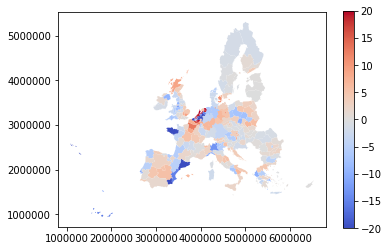

In [272]:
nuts_geo.join(t.rename('diff'), how='inner').plot('diff', cmap=mpl.cm.coolwarm, legend=True, vmin=-20, vmax=20)

In [19]:
uaa = refareas.A

In [20]:
old_terms_national = (
    old_terms
    .mul(old_data.UAA, axis=0)
    .join(nuts_table.country_code)
    .groupby('country_code')
    .sum()
    .div(uaa.mul(1e3), axis=0)
    .dropna()
)
old_terms_national

,excretion,harvest,mineral
AT,10.448826,-12.837188,5.244839
BE,32.189770,-22.773683,3.675434
BG,2.982451,-11.221968,2.506139
CY,20.406110,-4.322693,7.326443
CZ,6.748533,-14.714490,5.212704
DE,13.933231,-20.518786,7.429714
DK,19.585621,-21.976987,5.192568
EE,3.445708,-8.061848,3.267851
EL,7.074337,-6.058356,5.331928
ES,7.653902,-6.938892,8.112069


In [21]:
eust.read_table_metadata('aei_pr_gnb')['dimensions'].loc['indic_ag']

,label
code,
BAL,Gross Nutrient Balance (Inputs minus Outputs) ...
BAL_NET,Nett Nutrient Balance (Gross Nutrient Balance ...
BAL_NET_UAA,Nett Nutrient Balance per hectare UAA (kg of n...
BAL_UAA,Gross Nutrient Balance per hectare UAA (kg of ...
INP_NT,Nutrient inputs (tonnes of nutrient)
INP_UAA,Nutrient inputs per hectare UAA (kg of nutrien...
I_FRT,Total consumption of fertilisers (except manur...
I_FRT_MIN,Consumption of mineral fertilisers (tonnes of ...
I_FRT_ORG,Consumption of organic fertilisers (except man...


In [22]:
eub.columns

Index(['BAL', 'BAL_UAA', 'INP_NT', 'INP_UAA', 'I_FRT', 'I_FRT_MIN',
       'I_FRT_ORG', 'I_MNR', 'I_MNR_IMP', 'I_MNR_PCT', 'I_MNR_POTH',
       'I_MNR_PPG', 'I_MNR_PPL', 'I_MNR_PRD', 'I_MNR_PSP', 'I_MNR_WDR',
       'I_OTH', 'I_OTH_SEED', 'OUT_NT', 'OUT_UAA', 'O_BRN', 'O_CRP',
       'O_CRP_CER', 'O_CRP_FRU', 'O_CRP_IND', 'O_CRP_ORN', 'O_CRP_OTH',
       'O_CRP_PUL', 'O_CRP_ROO', 'O_CRP_VEG', 'O_FOD', 'O_FOD_PGA',
       'O_FOD_PGR', 'O_RES', 'UAA'],
      dtype='object', name='indic_ag')

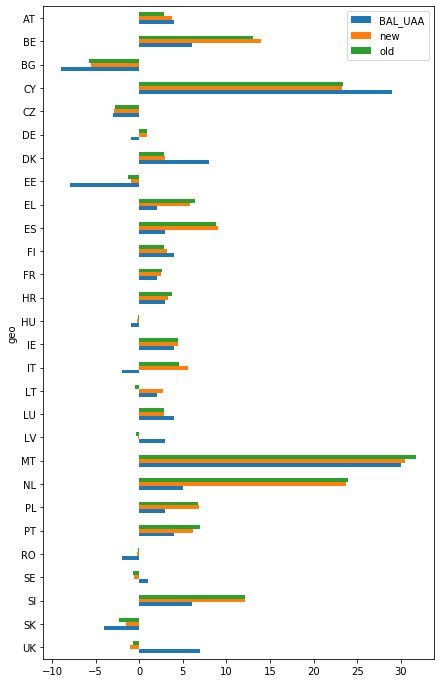

In [24]:
eub[['BAL_UAA']].join(national_surplus[0].rename('new')).join(old_s.rename('old')).dropna().sort_index(ascending=False).plot.barh(figsize=(7, 12))

In [28]:
comp = pd.concat({'Eurostat': eub_terms, 'new': new_terms, 'old': old_terms_national}, axis=1, sort=True).dropna().round(1)
comp

Eurostat                       new                       old  \
indic_ag excretion harvest mineral excretion harvest mineral excretion   
AT            11.6   -14.5     6.0      10.2   -12.8     6.3      10.4   
BE            28.4   -26.5     4.2      32.1   -22.4     4.3      32.2   
BG             2.6   -13.3     2.3       2.9   -11.0     2.5       3.0   
CY            31.6    -9.9     7.5      20.4    -4.4     7.3      20.4   
CZ             5.6   -14.7     5.2       6.6   -14.8     5.2       6.7   
DE            13.9   -24.0     7.4      13.8   -20.4     7.4      13.9   
DK            23.8   -22.7     5.2      19.4   -21.7     5.2      19.6   
EE             5.4   -16.0     3.3       3.4    -7.7     3.3       3.4   
EL             7.4    -9.8     4.7       6.5    -5.9     5.3       7.1   
ES             4.0    -7.6     6.0       7.7    -6.7     8.1       7.7   
FI             8.1    -9.6     5.0       6.7    -8.5     5.0       6.8   
FR            10.2   -15.6     7.6      11.8   -17.2     7.8      11.9   
HR             6.4   -11.1     8.0       6.7   -11.4     8.0       7.0   
HU             4.6   -11.9     6.3       5.7   -13.1     7.2       5.7   
IE            14.7   -19.0     8.3      13.7   -16.7     7.5      13.8   
IT            12.8   -20.6     6.0       9.2    -9.9     6.2       9.3   
LT             4.0   -11.4     9.8       3.2   -10.4     9.9       3.2   
LU            16.5   -16.4     3.9      16.5   -17.6     3.9      16.7   
LV             2.9    -6.0     5.7       2.9    -8.8     5.7       2.9   
MT            48.2   -21.8     2.6      33.8    -6.1     2.8      34.3   
NL            29.7   -28.5     2.2      44.1   -22.5     2.2      45.4   
PL             6.8   -15.3    11.9       7.2   -12.1    11.7       7.3   
PT             7.1    -7.1     4.7       7.2    -5.8     4.7       7.4   
RO             4.6    -9.9     3.6       4.8    -8.9     3.8       4.9   
SE             6.4   -11.2     3.9       6.9   -11.4     3.9       6.9   
SI            10.7   -13.2     8.1      13.7    -9.5     8.0      13.8   
SK             4.7   -11.8     5.4       4.6   -11.6     5.5       4.7   
UK            14.0   -16.9     7.0      11.6   -17.6     5.0      12.1   

                          
indic_ag harvest mineral  
AT         -12.8     5.2  
BE         -22.8     3.7  
BG         -11.2     2.5  
CY          -4.3     7.3  
CZ         -14.7     5.2  
DE         -20.5     7.4  
DK         -22.0     5.2  
EE          -8.1     3.3  
EL          -6.1     5.3  
ES          -6.9     8.1  
FI          -9.0     5.0  
FR         -17.1     7.8  
HR         -11.2     8.0  
HU         -13.0     7.1  
IE         -16.8     7.5  
IT         -10.9     6.2  
LT         -10.1     6.3  
LU         -17.7     3.9  
LV          -9.0     5.7  
MT          -5.4     2.8  
NL         -23.6     2.2  
PL         -12.3    11.7  
PT          -5.2     4.7  
RO          -8.9     3.8  
SE         -11.5     3.9  
SI          -9.7     8.0  
SK         -11.7     4.7  
UK         -17.8     5.0

In [ ]:
comp.xs('harvest', level='indic_ag', axis=1).assign(new2=lambda d: d.new - pgr_diff - pga_diff)[['Eurostat', 'new', 'new2']].plot.barh(figsize=(5, 12))

In [ ]:
eub[['BAL_UAA']].join(national_surplus[0].rename('new')).join(old_s.rename('old')).dropna().sort_values('BAL_UAA').plot.barh(figsize=(7, 12))